# Simulation, Imputation and Evaluation of the datasets

This is the main data generation notebook. It processes the datasets, imputes them and evaluates the imputation performance. The imputation performance is evaluated for different missingness mechanisms and different missingness rates.


In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns
import re
import ast
from tqdm import tqdm
import sklearn
from joblib import Parallel, delayed

# Matplotlib command for Jupyter notebooks only
%matplotlib inline
plt.style.use('tableau-colorblind10')

In [2]:
# importing custom functions for imputation and evaluation
import sys

sys.path.append("/home/mklein/sc_imputation_denoising")
import sc_imputation_denoising as scid

from sc_imputation_denoising.imputation.constants import const

from sc_imputation_denoising.evaluation.evaluation_workflow import (
    evaluation_workflow,
)
from sc_imputation_denoising.imputation.simulation import (
    get_dropout_rate,
)

sim_method = "mcar"

# number of cores to use for parallelization
n_jobs = 5

IE version 1.2


In [3]:
# importing different imputation/denoising packages
# MAGIC
import magic
import graphtools
# ALRA
import sys
sys.path.append('/home/mklein/ALRA')
from alra import alraInstance

# Simple methods
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer


In [100]:
# fallback parameters if the script is run without command line arguments
dataset = 'Lx_Pancreatic_Cancer'
simulation_method = "mnar"
repl = 1

In [5]:
if dataset == 'Lx_Pancreatic_Cancer':
    max_fdr = 1
    n_cells = 0.2
    n_ions = 0.05
elif dataset == 'Lx_HepaRG':
    max_fdr = 1
    n_cells = 0.2
    n_ions = 0.2
elif dataset == 'Lx_Glioblastoma':
    max_fdr = 1
    n_cells = 0.05
    n_ions = 0.05
elif dataset == 'Mx_Seahorse':
    max_fdr = 1
    n_cells = 0.1
    n_ions = 0.2


In [67]:
if dataset in ['Mx_Seahorse', 'Lx_Glioblastoma', 'Lx_HepaRG']:
    run_imputations = ['magic', 'alra', 'knn', 'dca', 'fancy', 'ctrl']
else:
    run_imputations = ['magic', 'alra', 'bbmagic', 'knn', 'dca', 'fancy', 'ctrl']

# run_imputations = []

In [68]:
adata_raw = sc.read(f'/home/mklein/Dropouts/data/{dataset}.h5ad')

if dataset == 'Mx_Seahorse':
    adata_raw = adata_raw[~adata_raw.obs['well'].isin(['A3', 'G1', 'J2', 'E2', 'E3', 'E4'])]
    #adata_raw = adata_raw[adata_raw.obs['dataset_0'].isin(['Stim', 'NStim'])]
    adata_raw.obs['batch'] = 'none'
    adata_raw.obs['condition'] = adata_raw.obs['dataset_0']

elif dataset == 'Lx_Glioblastoma':
    well_name= 'well'
    condition_name='condition'

    metadata_path = os.path.join("/home/mklein/Dropouts/data/metaspace_datasets_GlioblastomaNEW.csv")
    samples = list(set(adata_raw.obs['well']))

    if os.path.exists(metadata_path):
        metadata = pd.read_csv(metadata_path)
        if well_name not in metadata.columns:
            metadata[well_name] = metadata['row'].astype(str) + metadata['col'].astype(str)
        samples = list(metadata[well_name])

    def assign_conditions(adata):

        index = adata.obs.index.name
        if condition_name in adata.obs.columns:
            del adata.obs[condition_name]
        new_obs = adata.obs.reset_index()

        new_obs = pd.merge(new_obs, metadata[[well_name, condition_name]], 
                           how='inner', left_on='well', right_on=well_name).set_index(index)

        adata = adata[new_obs.index, :].copy()
        adata.obs = new_obs
        if 'keep_conditions' in globals():
            adata = adata[adata.obs[condition_name].isin(keep_conditions), :].copy()
        return adata

    adata_raw = assign_conditions(adata_raw)
    adata_raw.obs['batch'] = 'none'

elif dataset == 'Lx_Pancreatic_Cancer':
    adata_raw.obs['dataset'] = 'none'
    adata_raw.obs['batch'] = adata_raw.obs['dataset_2']
    adata_raw.obs['sample'] = adata_raw.obs['well']
    metadata = pd.read_csv('/home/mklein/Dropouts/data/PancreaticCancer_datasets.csv')
    metadata['sample'] = "S" + metadata['slide'].astype(str) + "_W" + metadata['well'].astype(str)
    merge_df = pd.merge(adata_raw.obs, metadata[['sample', 'condition']], how="inner", on="sample")
    merge_df.index = adata_raw.obs_names
    adata_raw.obs = merge_df
    adata_raw.var['fdr'] = 1

elif dataset == 'Lx_HepaRG':
    adata_raw.X = adata_raw.raw.X
    adata_raw.obs['sample'] = adata_raw.obs['slide_id']
    adata_raw.obs['well'] = adata_raw.obs['slide_id']
    adata_raw.var['fdr'] = 1

    
get_dropout_rate(adata_raw, layer=None)
print(adata_raw.shape)

adata_raw = adata_raw[:, adata_raw.var['fdr'].replace(np.nan, 1) <= max_fdr].copy()
sc.pp.filter_cells(adata_raw, min_genes=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

get_dropout_rate(adata_raw, layer=None)
print(adata_raw.shape)
cell_qc_df, ion_qc_df = sc.pp.calculate_qc_metrics(adata_raw, percent_top=None)
adata_raw.obs[['condition', 'well']].value_counts(sort=False)

/tmp/ipykernel_238/1161204569.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_raw.obs['batch'] = 'none'


Global dropout rate: 72.36 Percent
(9908, 1004)
Global dropout rate: 71.27 Percent
(9908, 966)


condition  well
2DG        B3      1178
           H3      1478
           F3      1519
NStim      D1       761
           C1       746
           B1       367
           E1       717
Oligo      B4       238
           H4       491
           F4       348
           G4       394
Stim       A2       559
           F2      1112
dtype: int64

In [69]:
if type(n_ions) is int:
    min_ions = n_ions
    perc_ions = n_ions / len(adata_raw.var_names)
else:
    min_ions = int(n_ions * len(adata_raw.var_names))
    perc_ions = n_ions

if type(n_cells) is int:
    min_cells = n_cells
    perc_cells = n_cells / len(adata_raw.obs_names)
else:
    min_cells = int(n_cells * len(adata_raw.obs_names))
    perc_cells = n_cells

In [70]:
def run_umap(adata, layer=None, prep = False):
    adata_c = adata.copy()
    if prep:
        sc.pp.normalize_total(adata_c, target_sum=1e4)
        sc.pp.log1p(adata_c)
    if layer is not None:
        adata_c.X = adata.layers[layer]
    sc.pp.pca(adata_c)
    sc.pp.neighbors(adata_c)
    sc.tl.umap(adata_c)
    sc.pl.umap(adata_c, color=['condition', 'well'], frameon=False)

In [71]:
cond = len(adata_raw.obs['condition'].unique())
conf = f"cond{cond}_{simulation_method}_c{n_cells}_i{n_ions}_fdr{max_fdr}_repl{repl}"
save_to = f"/g/alexandr/Marius/imputation_evaluation/{dataset}_{conf}"
if not os.path.exists(save_to):
    os.makedirs(save_to)
print(save_to)

/g/alexandr/Marius/imputation_evaluation/Mx_Seahorse_cond4_mcar_c0.0_i0.2_fdr1_repl8


Mx


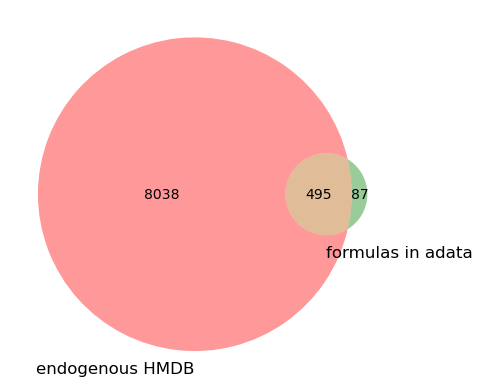

Molecule names that are both not endogenous and not essential
['["Amrinone"]', '["2-Aminoquinoline", "5-Methylquinoxaline"]', '["Ciprofloxacin"]', '["Chrycolide"]', '["Mefloquine"]', '["Permethrin"]', '["3-Acetyl-2,7-naphthyridine", "4-Hydroxy-1H-indole-3-acetonitrile"]', '["Amoxicillin", "Amoxycillin"]', '["Quindoxin"]', '["Harman"]', '["Garcinia lactone dibutyl ester"]', '["Fosfomycin"]', '["Acamprosate"]', '["N-Propionylmethionine"]', '["Tolazamide"]', '["Tolnaftate"]', '["8-Anilino-1-naphthalene sulfonate"]', '["2,3-Diphenylpyrazine"]', '["N\'-Hydroxyneosaxitoxin"]', '["6-(2-amino-2-carboxyethyl)-4-hydroxybenzothiazole"]', '["S-Adenosyl methionine", "S-Adenosylmethionine", "S-adenosyl-L-methioninate"]', '["Methyl 4-chloro-1H-indole-3-acetate"]', '["Sotalol"]', '["Methylphosphate"]', '["3\',5\'-Cyclic dAMP"]', '["Brassicanal C"]', '["2-Aminonaphthalene", "6-Methylquinoline", "Quinaldine"]', '["Milrinone"]', '["1-Methoxy-1H-indole-3-acetonitrile"]', '["9-aminoacridine"]', '["Epinasti

In [72]:
if dataset[:2] == "Lx": 
    adata = adata_raw.copy()
    print('Lx')
else:
    endogenous_df = pd.read_csv('/home/mklein/Correlations/prep/hmdb_4-endogenous.tsv', sep = '\t')
    manually_endogenous = ['Biotin', 'L-Histidine', 'Pantothenate', 'Creatine riboside', 'Phosphate', 'Thiamine', 'Pyrophosphate']

    adata = adata_raw[:, 
    (adata_raw.var['formula'].isin(endogenous_df['formula'])) | # ions that are in endogenous HMDB database
    (adata_raw.var['moleculeNames'].str.contains('"' + '"|"'.join(manually_endogenous) + '"', flags=re.IGNORECASE, regex=True, na=False))
        # ions that were manually curated 'essential'
    ].copy()
    print('Mx')

    from matplotlib_venn import venn2 
    from matplotlib import pyplot as plt
      
    # depict venn diagram
    venn2([set(endogenous_df['formula']), set(adata_raw.var['formula'])], ('endogenous HMDB', 'formulas in adata'))
    plt.show()
    print('Molecule names that are both not endogenous and not essential')
    print(list(set(adata_raw.var[
        (~adata_raw.var['formula'].isin(endogenous_df['formula'])) &
        (~adata_raw.var['formula'].isin(adata.var['formula']))
    ]['moleculeNames'])))

print(adata.shape)

In [73]:
cell_qc = pd.merge(adata.obs, cell_qc_df, left_index=True, right_index=True)
ion_qc = pd.merge(adata.var, ion_qc_df, left_index=True, right_index=True)
ion_qc['fdr'] = ion_qc['fdr'].replace(np.nan, 1)
cell_qc['condition'].value_counts()

2DG      4175
NStim    2591
Stim     1671
Oligo    1471
Name: condition, dtype: int64

Global dropout rate: 73.00 Percent


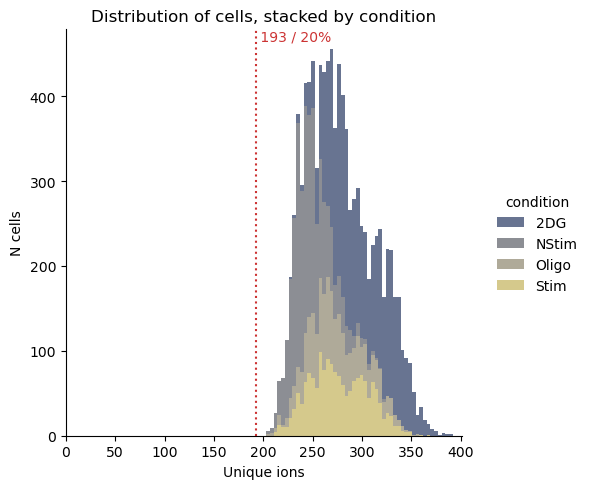

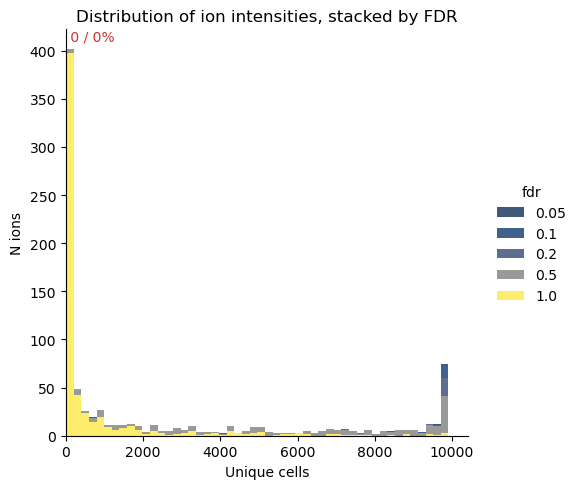

In [99]:
ipl = sns.displot(data=cell_qc, x="n_genes_by_counts", bins=50, linewidth=0, hue='condition', palette='cividis', multiple='stack')
ipl_ax = ipl.axes.flat[0]
ipl_ax.set_xlabel('Unique ions')
ipl_ax.set_ylabel('N cells')
ipl_ax.set_xlim(left=0)
ipl_ax.set_title('Distribution of cells, stacked by condition')
ipl_ax.axvline(x=min_ions, linestyle=":", c="#CC3333")
ipl_ax.text(x=min_ions, y=ipl_ax.get_ylim()[1], s=f" {min_ions} / {perc_ions:.0%}", va='top', ha='left', color="#CC3333")

ipl.tight_layout()
ipl.fig.savefig(os.path.join(save_to, 'ion_filtering.pdf')) 

cpl = sns.displot(data=ion_qc, x="n_cells_by_counts", hue='fdr', palette='cividis', bins=50, linewidth=0, multiple="stack")
cpl_ax = cpl.axes.flat[0]
cpl_ax.set_xlabel('Unique cells')
cpl_ax.set_ylabel('N ions')
cpl_ax.set_xlim(left=0)
cpl_ax.set_title('Distribution of ion intensities, stacked by FDR')
cpl_ax.axvline(x=min_cells, linestyle=":", c="#CC3333")
cpl_ax.text(x=min_cells, y=cpl_ax.get_ylim()[1], s=f" {min_cells} / {perc_cells:.0%}", va='top', ha='left', color="#CC3333")
cpl.tight_layout()
cpl.fig.savefig(os.path.join(save_to, 'cell_filtering.pdf')) 


sc.pp.filter_cells(adata, min_genes=min_ions)
sc.pp.filter_genes(adata, min_cells=min_cells)

# get rid of cells that have no ions left after last filtering step
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)
adata.raw = adata
wflow = evaluation_workflow(
    adata = adata,
    sample_col = 'well',
    condition_col = 'condition',
)

In [75]:
sc.pp.normalize_total(wflow.dataset, target_sum=1e4)
sc.pp.log1p(wflow.dataset)
get_dropout_rate(wflow.dataset, layer=None)
print(wflow.dataset.shape)

Global dropout rate: 73.34 Percent
(7926, 874)


In [80]:
pd.crosstab(wflow.dataset.obs['well'], wflow.dataset.obs['condition'], margins=True)

condition,2DG,NStim,Oligo,Stim,All
well,,,,,
B3,1151,0,0,0,1151
B4,0,0,122,0,122
A2,0,0,0,406,406
D1,0,384,0,0,384
H4,0,0,452,0,452
H3,1473,0,0,0,1473
F4,0,0,315,0,315
F3,1509,0,0,0,1509
F2,0,0,0,1036,1036


In [81]:
n_sims = 0
if simulation_method == 'mnar':
    wflow.simulate_dropouts(n_logspace=n_sims, method=simulation_method, value_importance=2, v=False)
else:
    wflow.simulate_dropouts(n_logspace=n_sims, method=simulation_method, v=False)

Generated 1 datasets with increasing dropout rates: 0.733371501029835
simulating dropout rates [0.733371501029835] with method mcar
supplied adata has raw attribute. Simulating dropouts here aswell. You can preven this by setting argument simulate_raw=False


Imputation using vanilla MAGIC

In [19]:
t_steps = [1, 2, 3, 5]
# t_steps, knn_steps = [2], [3]
if 'magic' in run_imputations:
    for k,adata in wflow.dataset_dict.items():
            
        magic_op = magic.MAGIC(
            knn=3,
            n_pca=100)
        magic_op.fit(adata.to_df(layer="ctrl"))
        
        for t in t_steps:
            magic_op.set_params(t=t)
            adata.layers[f"MAGIC_t{t}"] = magic_op.transform()

Running MAGIC on 7180 cells and 341 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.68 seconds.
  Calculating KNN search...
  Calculated KNN search in 5.90 seconds.
  Calculating affinities...


/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 298 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


  Calculated affinities in 5.65 seconds.
Calculated graph and diffusion operator in 13.25 seconds.
Calculating imputation...
Calculated imputation in 0.04 seconds.
Calculating imputation...
Calculated imputation in 0.05 seconds.
Calculating imputation...
Calculated imputation in 0.06 seconds.
Calculating imputation...
Calculated imputation in 0.11 seconds.
Running MAGIC on 7180 cells and 341 genes.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.45 seconds.
  Calculating KNN search...
  Calculated KNN search in 6.13 seconds.
  Calculating affinities...
  Calculated affinities in 5.88 seconds.
Calculated graph and diffusion operator in 13.48 seconds.
Calculating imputation...
Calculated imputation in 0.03 seconds.
Calculating imputation...
Calculated imputation in 0.05 seconds.
Calculating imputation...
Calculated imputation in 0.07 seconds.
Calculating imputation...
Calculated imputation in 0.12 seconds.
Running MAGIC on 7180 cells and 341 genes.


In [20]:
import bbmagic as bm
if 'bbmagic' in run_imputations:
    for k,adata in wflow.dataset_dict.items():
        
        for t in t_steps:
            bm.bb_magic(adata, t=t, layer_from='ctrl', layer_to=f"bbmagic_{t}", n_jobs=n_jobs)

2023-05-24 23:00:36.651913: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imputation using ALRA

In [21]:
if 'alra' in run_imputations:
    al = alraInstance()
    # if required r packages are not installed, run the following line
    al.install_r_packages() 
    al.r('.libPaths("/home/mklein/miniconda3/envs/dropout_env/lib/R/library")')

    for k,adata in wflow.dataset_dict.items():
            
        _, _, adata.layers[f"ALRA"] = al.alra(adata.layers['ctrl'])

/home/mklein/ALRA/alra.py:20: UserWarning: R package rsvd is required for ALRA. Please run alraInstance.install_r_packages() to install it.
  warnings.warn('R package rsvd is required for ALRA. Please run ' +


R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/mklein/miniconda3/envs/env_all/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

loaded via a namespace (and not attached):
[1] compiler_4.2.2



R[write to console]: trying URL 'http://cran.us.r-project.org/src/contrib/rsvd_1.0.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3458090 bytes (3.3 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to conso

Read matrix with 7180 cells and 341 genes
Chose k=26
Getting nonzeros
Randomized SVD
Find the 0.001000 quantile of each gene
Sweep
Scaling all except for 0 columns
0.03% of the values became negative in the scaling process and were set to zero
The matrix went from 66.30% nonzero to 85.82% nonzero
Read matrix with 7180 cells and 341 genes
Chose k=32
Getting nonzeros
Randomized SVD
Find the 0.001000 quantile of each gene
Sweep
Scaling all except for 0 columns
0.02% of the values became negative in the scaling process and were set to zero
The matrix went from 61.00% nonzero to 87.76% nonzero
Read matrix with 7180 cells and 341 genes
Chose k=67
Getting nonzeros
Randomized SVD
Find the 0.001000 quantile of each gene
Sweep
Scaling all except for 0 columns
0.02% of the values became negative in the scaling process and were set to zero
The matrix went from 54.00% nonzero to 84.40% nonzero
Read matrix with 7180 cells and 341 genes
Chose k=16
Getting nonzeros
Randomized SVD
Find the 0.001000 qua

Imputation using simple methods

In [15]:
if 'knn' in run_imputations:
    for k,adata in wflow.dataset_dict.items():
        # simple kNN imputer 
        print(k)
        for nn in [1, 3, 5]:
            print(nn)
            imputer = KNNImputer(missing_values=0, n_neighbors=nn, weights="uniform", keep_empty_features=True)
            adata.layers[f"knn_{nn}"] = imputer.fit_transform(np.array(adata.layers['ctrl']))
        


0.34_baseline
1


KeyboardInterrupt: 

In [21]:
# if 'ctrl' in run_imputations:
#     for k,adata in i_e.dataset_dict.items():    
#         # mean
#         mean_imputer = SimpleImputer(missing_values=0, strategy='mean', keep_empty_features=True)
#         mean_imputer.fit(adata.layers['ctrl'])
#         adata.layers[f"ctrl_mean"] = mean_imputer.transform(adata.layers['ctrl'])
        

In [83]:
from fancyimpute import SimpleFill
if 'ctrl' in run_imputations:
    for k,adata in wflow.dataset_dict.items():    

        array = np.copy(adata.layers["ctrl"])
        array[array == 0] = np.nan

        adata.layers[f"ctrl_random"] = SimpleFill(fill_method='random').fit_transform(array)
        adata.layers[f"ctrl_median"] = SimpleFill(fill_method='median').fit_transform(array)
        adata.layers[f"ctrl_mean"] = SimpleFill(fill_method='mean').fit_transform(array)
        

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/fancyimpute/solver.py:66: RuntimeWarning: Mean of empty slice
  fill_values = col_fn(col_data)


In [ ]:
# if 'ctrl' in run_imputations:
#     for k,adata in i_e.dataset_dict.items():
#         # half-minimum
#         half_min_array = adata.layers['ctrl'].copy()
#         half_min_array[half_min_array == 0] = np.min(half_min_array[half_min_array != 0]) / 2
#         adata.layers[f"ctrl_halfmin"] = half_min_array

In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

def run_iterative(X):

    only_zero = np.all(X == 0, axis=0)
    print(str(X[:,only_zero].shape[1]) + ' ion missing completely')
    missing_array = X[:,~only_zero]
    missing_array[missing_array == 0] = np.nan
    max_values = np.nanmax(missing_array, axis=0)

    iter_imputer = IterativeImputer(missing_values=np.nan, min_value=0, max_value=max_values, verbose=2, random_state=1, max_iter=20)
    iter_imputer.fit(missing_array)

    x_out = np.zeros(X.shape)
    x_out[:, ~only_zero] = iter_imputer.transform(missing_array)

    return x_out

if 'fancy' in run_imputations:
    x_list = [adata.layers['ctrl'] for k,adata in wflow.dataset_dict.items()]

    # x_out_list = Parallel(n_jobs=len(x_list), verbose=50)(delayed(run_iterative)(x) for x in tqdm(x_list))
    x_out_list = [run_iterative(x) for x in tqdm(x_list)]

    for i, (k,adata) in enumerate(wflow.dataset_dict.items()):
        adata.layers[f"fancy_multi"] = x_out_list[i]


In [ ]:
%%time

from fancyimpute import BiScaler, SoftImpute, IterativeSVD

if 'fancy' in run_imputations:
    for k,adata in i_e.dataset_dict.items():
        print(k)
        array = np.copy(adata.layers["ctrl"])
        only_zero = np.all(array == 0, axis=0)
        array[array == 0] = np.nan
        array[:, only_zero] = 0  # only zero columns are not imputed

        biscaler = BiScaler()
        X_incomplete_normalized = biscaler.fit_transform(array)
        X_imputed = SoftImpute(min_value=0).fit_transform(X_incomplete_normalized)
        adata.layers[f"fancy_softbi"] = biscaler.inverse_transform(X_imputed)

        adata.layers[f"fancy_soft"] = SoftImpute(min_value=0).fit_transform(array)

        adata.layers[f"fancy_itersvd"] = IterativeSVD(rank=100, min_value=0).fit_transform(array)

In [ ]:
# for k,adata in i_e.dataset_dict.items():
#     for nn in [1, 3, 5]:
#         if f"knn_{nn}" in adata.layers:
#             del adata.layers[f"knn_{nn}"]

In [7]:
if run_imputations != []:
    print('Imputations done, saving to pickle')
    wflow.save_to_pickle(save_to=f'/scratch/klein/temp/evaluation_pickle_{dataset}_{conf}_{repl}.pkl')

In [ ]:
# import nbformat
# from nbconvert.preprocessors import ExecutePreprocessor
# 
# with open("/home/mklein/Dropouts/evaluation/DCA_for_evaluation.ipynb") as f:
#     nb = nbformat.read(f, as_version=4)
# 
# ep_python = ExecutePreprocessor(timeout=600, kernel_name='dca_env')
# 
# # path specifies which folder to execute the notebooks in, so set it to the one that you need so your file path references are correct
# _ = ep_python.preprocess(nb, {'metadata': {'path': '.'}})

In [70]:
import papermill as pm
if 'dca' in run_imputations:
    pm.execute_notebook(
        "/home/mklein/Dropouts/evaluation/DCA_for_evaluation.ipynb",
        "/home/mklein/Dropouts/evaluation/DCA_for_evaluation_out.ipynb",
        kernel_name='dca_env',
        parameters=dict(dataset=dataset, conf=conf, repl=repl)
    )


Executing:   0%|          | 0/11 [00:00<?, ?cell/s]

2023-05-25 07:06:16.954843: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 07:06:17.434545: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-05-25 07:06:17.459123: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


In [ ]:
import gc
gc.collect()

In [11]:
wflow = evaluation_workflow.get_from_pickle(f'/scratch/klein/temp/evaluation_pickle_{dataset}_{conf}_{repl}.pkl')

In [12]:
wflow.dataset_dict[wflow.baseline_key]


AnnData object with n_obs × n_vars = 7926 × 348
    obs: 'center_x', 'center_y', 'cell_area', 'cell_sampling_area', 'cell_sampling_ratio', 'cell_nearest_am_distance', 'cell_nearest_cell_distance', 'centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'local_centroid-0', 'local_centroid-1', 'area', 'filled_area', 'solidity', 'perimeter', 'eccentricity', 'euler_number', 'moments_hu-0', 'moments_hu-1', 'moments_hu-2', 'moments_hu-3', 'moments_hu-4', 'moments_hu-5', 'moments_hu-6', 'moments_central-0-0', 'moments_central-0-1', 'moments_central-0-2', 'moments_central-0-3', 'moments_central-1-0', 'moments_central-1-1', 'moments_central-1-2', 'moments_central-1-3', 'moments_central-2-0', 'moments_central-2-1', 'moments_central-2-2', 'moments_central-2-3', 'moments_central-3-0', 'moments_central-3-1', 'moments_central-3-2', 'moments_central-3-3', 'inertia_tensor_eigvals-0', 'inertia_tensor_eigvals-1', 'major_axis_length', 'minor_axis_length', 'weighted_moments_central-0-0-DAPI', 

In [ ]:
# calculate PCA and UMAP coordinates and save them to pickle for reference
wflow.init_analysis(n_jobs=n_jobs)
wflow.save_to_pickle(save_to=f'/scratch/klein/temp/evaluation_pickle_{dataset}_{conf}_{repl}.pkl')

Precalculating PCs and UMAPs


  0%|          | 0/21 [00:00<?, ?it/s]

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


 48%|████▊     | 10/21 [00:00<00:00, 38.58it/s]2023-05-24 21:12:07.887685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 21:12:07.887684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 21:12:07.887684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performanc

[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  4.1min


[Parallel(n_jobs=10)]: Done   2 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done   3 out of  21 | elapsed:  4.1min remaining: 24.9min
[Parallel(n_jobs=10)]: Done   4 out of  21 | elapsed:  4.3min remaining: 18.1min
[Parallel(n_jobs=10)]: Done   5 out of  21 | elapsed:  4.3min remaining: 13.8min
[Parallel(n_jobs=10)]: Done   6 out of  21 | elapsed:  4.3min remaining: 10.8min
[Parallel(n_jobs=10)]: Done   7 out of  21 | elapsed:  4.4min remaining:  8.7min
[Parallel(n_jobs=10)]: Done   8 out of  21 | elapsed:  4.4min remaining:  7.1min
[Parallel(n_jobs=10)]: Done   9 out of  21 | elapsed:  4.4min remaining:  5.8min
[Parallel(n_jobs=10)]: Done  10 out of  21 | elapsed:  4.4min remaining:  4.8min
[Parallel(n_jobs=10)]: Done  11 out of  21 | elapsed:  4.5min remaining:  4.1min
[Parallel(n_jobs=10)]: Done  12 out of  21 | elapsed:  4.5min remaining:  3.4min
[Parallel(n_jobs=10)]: Done  13 out of  21 | elapsed:  4.5min remaining:  2.8min
[Parallel(n_jobs=10)]: Done  14 out of  21 | el

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, mean_squared_error, silhouette_score, davies_bouldin_score, calinski_harabasz_score

n_clusters = len(wflow.dataset.obs[const.CONDITION_COL].value_counts())

def _evaluate_imputation(params):
    l = params
    adata = l['adata']
    ad_ctrl = wflow.dataset.to_df()

    # sc.pp.pca(adata)
    # sc.pp.neighbors(adata, n_neighbors=50, metric='cosine')
    # sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)

    u_df = sc.get.obs_df(
        adata, 
        keys=[const.SAMPLE_COL, const.BATCH_COL, const.CONDITION_COL] + wflow.analysis_ions, 
        obsm_keys=[("X_umap", 0), ("X_umap", 1)]
    )   
    
    # random forest
    # clf = RandomForestClassifier(n_estimators = 50, oob_score=True)  
    # clf.fit(adata.X, adata.obs['condition'])

    #ARI
    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        random_state=1,
        n_init = 10
    )

    kmeans.fit(adata.X) 

    # subsetting cells if more than 15000 for speed
    if len(adata.obs_names) > 10000:
        print(f"subsetting {l['imputation']}_{l['dropout_ratio']} with N_obs={len(adata.obs_names)} to 10k")
        N = 10000
        subset = adata.obs.groupby('condition', group_keys=False).apply(
            lambda x: 
                x.sample(int(np.rint(N*len(x)/len(adata.obs))))
            ).sample(frac=1).reset_index(drop=True)
    else:
        subset = adata.obs

    corr_ions_matrix = adata.to_df().corr()
    out_df = pd.DataFrame(dict(
        corr_ions = np.nanmean(corr_ions_matrix, axis=None),
        corr_ions_diff = np.abs(np.nanmean(corr_ions_matrix - wflow.dataset.to_df().corr(), axis=None)),
        corr_cells = np.nanmean(adata[subset.index].to_df().T.corr(), axis=None),
        variance_mse = mean_squared_error(ad_ctrl.var(), adata.to_df().var()),
        mse = mean_squared_error(wflow.dataset.X.flatten(), adata.X.flatten()),
        ari = adjusted_rand_score(adata.obs[const.CONDITION_COL], kmeans.labels_),
        silhouette = silhouette_score(u_df[['X_umap-0', 'X_umap-1']], u_df[const.CONDITION_COL]),
        davies_bouldin = davies_bouldin_score(adata.X, adata.obs[const.CONDITION_COL]),
        calinski_harabasz = calinski_harabasz_score(adata.X, adata.obs[const.CONDITION_COL]),
        # oob_score = clf.oob_score_,
        imputation=l['imputation'],
        dr=l['dropout_ratio']
    ), index=[f"{l['imputation']}_{l['dropout_ratio']}"])


    return out_df

# these calculations are a bit heavier, running >5 in parallel can lead to memory issues
df = wflow.analyse_imputation(function = _evaluate_imputation, n_jobs=5, verbose=50)
df

/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/mklein/miniconda3/envs/env_all/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest

IE version 1.2
IE version 1.2
IE version 1.2
IE version 1.2


  5%|▍         | 1/21 [00:06<02:14,  6.75s/it]

IE version 1.2
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


 48%|████▊     | 10/21 [00:49<00:54,  4.94s/it]

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:   43.2s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:   45.8s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:   45.9s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:   46.1s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:   46.2s


 71%|███████▏  | 15/21 [01:30<00:37,  6.28s/it]

[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:  1.5min


100%|██████████| 21/21 [02:10<00:00,  6.23s/it]

[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:  2.1min


[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  13 out of  21 | elapsed:  2.2min remaining:  1.3min
[Parallel(n_jobs=5)]: Done  14 out of  21 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=5)]: Done  15 out of  21 | elapsed:  2.2min remaining:   52.3s
[Parallel(n_jobs=5)]: Done  16 out of  21 | elapsed:  2.7min remaining:   51.5s
[Parallel(n_jobs=5)]: Done  17 out of  21 | elapsed:  2.8min remaining:   39.5s
[Parallel(n_jobs=5)]: Done  18 out of  21 | elapsed:  2.9min remaining:   28.7s
[Parallel(n_jobs=5)]: Done  19 out of  21 | elapsed:  2.9min remaining:   18.1s
[Parallel(n_jobs=5)]: Done  21 out of  21 | elapsed:  3.4min remaining:    0.0s
[Parallel(n_jobs=5)]: Done  21 out of  21 | elapsed:  3.4min finished


,corr_ions_diff,corr_cells,variance_mse,mse,ari,silhouette,davies_bouldin,calinski_harabasz,imputation,dr,dropout_ratio
ctrl_0.34_baseline,0.000000e+00,0.736548,0.000000e+00,0.000000e+00,0.177148,0.067657,4.686285,245.551484,ctrl,0.34_baseline,0.34
ctrl_mean_0.34_baseline,4.587387e-02,0.852129,5.316898e-01,1.156376e+00,0.092721,0.061890,6.461933,147.771718,ctrl_mean,0.34_baseline,0.34
ctrl_halfmin_0.34_baseline,3.695438e-08,0.736550,5.184226e-10,4.450371e-10,0.176777,0.063500,4.686282,245.551925,ctrl_halfmin,0.34_baseline,0.34
ctrl_0.39,3.524024e-03,0.614317,4.434659e-01,4.948147e-01,0.182663,0.036520,6.244367,136.103541,ctrl,0.39,0.39
ctrl_mean_0.39,4.166498e-02,0.861321,5.545802e-01,1.174723e+00,0.088705,0.059083,6.732902,135.116402,ctrl_mean,0.39,0.39
ctrl_halfmin_0.39,3.524023e-03,0.614319,4.434491e-01,4.948042e-01,0.182663,0.043169,6.244375,136.103313,ctrl_halfmin,0.39,0.39
ctrl_0.46,4.809709e-03,0.483848,1.843513e+00,1.147579e+00,0.139493,-0.033064,8.112555,79.656906,ctrl,0.46,0.46
ctrl_mean_0.46,3.588122e-02,0.873997,5.859951e-01,1.197078e+00,0.091935,0.047746,7.191252,119.184924,ctrl_mean,0.46,0.46
ctrl_halfmin_0.46,4.809708e-03,0.483850,1.843448e+00,1.147555e+00,0.139412,-0.032300,8.112587,79.656505,ctrl_halfmin,0.46,0.46
ctrl_0.54,5.736297e-03,0.366790,3.596520e+00,1.893398e+00,0.103018,0.010458,10.304692,48.588395,ctrl,0.54,0.54


In [ ]:
# i_e.save_to_pickle(save_to=f'/scratch/klein/temp/evaluation_pickle_{dataset}_{conf}_{repl}.pkl')

In [ ]:
df['simulation'] = simulation_method
df.to_csv(f'{save_to}/evaluation.csv')

In [102]:
df = pd.read_csv(f'{save_to}/evaluation.csv', index_col=0)
df

,corr_ions,corr_ions_diff,corr_cells,variance_mse,mse,ari,silhouette,davies_bouldin,calinski_harabasz,imputation,dr,dropout_ratio,simulation
ctrl_0.26_baseline,0.013648,0.000000,0.704168,0.000000,0.000000,0.256100,0.067262,4.756342,342.071499,ctrl,0.26_baseline,0.26,mcar
MAGIC_t1_0.26_baseline,0.023391,0.009743,0.838397,0.253165,0.206868,0.257713,0.047408,3.157899,817.620106,MAGIC_t1,0.26_baseline,0.26,mcar
MAGIC_t2_0.26_baseline,0.030471,0.016823,0.877333,0.390944,0.343192,0.241329,0.047695,2.677310,1178.868411,MAGIC_t2,0.26_baseline,0.26,mcar
MAGIC_t3_0.26_baseline,0.034802,0.021154,0.895165,0.462879,0.423074,0.245168,0.051668,2.465937,1433.719832,MAGIC_t3,0.26_baseline,0.26,mcar
MAGIC_t5_0.26_baseline,0.037551,0.023903,0.914024,0.547868,0.501972,0.255364,0.053942,2.281712,1787.352238,MAGIC_t5,0.26_baseline,0.26,mcar
ALRA_0.26_baseline,0.057808,0.044159,0.711841,0.107077,0.580029,0.211440,0.088105,3.496020,634.897344,ALRA,0.26_baseline,0.26,mcar
knn_1_0.26_baseline,0.085148,0.071500,0.816813,0.582465,1.167624,0.151869,0.078447,6.316414,289.174074,knn_1,0.26_baseline,0.26,mcar
knn_3_0.26_baseline,0.091673,0.078025,0.826958,0.609633,1.157889,0.150258,0.076449,6.132049,305.458290,knn_3,0.26_baseline,0.26,mcar
knn_5_0.26_baseline,0.093415,0.079767,0.829248,0.615569,1.156214,0.150484,0.077779,6.102551,308.224128,knn_5,0.26_baseline,0.26,mcar
ctrl_random_0.26_baseline,0.040395,0.026747,0.770116,0.476271,1.173684,0.132405,0.068659,8.535066,135.248622,ctrl_random,0.26_baseline,0.26,mcar


In [103]:
# eval_df = df.set_index(['dropout_ratio', 'imputation']).groupby('dr', group_keys=True).apply(scipy.stats.zscore).reset_index()
df['group'] = list(df['imputation'].apply(lambda x: re.sub('_[^_]+$', '', x)))
df = df.set_index(['dropout_ratio', 'dr', 'imputation', 'group', 'simulation'])

df['corr_ions_diff'] = -df['corr_ions_diff']
df['mse'] = -df['mse']
df['variance_mse'] = -df['variance_mse']
df['davies_bouldin'] = -df['davies_bouldin']
df


corr_ions  \
dropout_ratio dr            imputation        group simulation              
0.26          0.26_baseline ctrl              ctrl  mcar         0.013648   
                            MAGIC_t1          MAGIC mcar         0.023391   
                            MAGIC_t2          MAGIC mcar         0.030471   
                            MAGIC_t3          MAGIC mcar         0.034802   
                            MAGIC_t5          MAGIC mcar         0.037551   
                            ALRA              ALRA  mcar         0.057808   
                            knn_1             knn   mcar         0.085148   
                            knn_3             knn   mcar         0.091673   
                            knn_5             knn   mcar         0.093415   
                            ctrl_random       ctrl  mcar         0.040395   
                            ctrl_median       ctrl  mcar         0.067466   
                            ctrl_mean         ctrl  mcar         0.061684   
                            fancy_multi       fancy mcar         0.103187   
                            fancy_softbi      fancy mcar         0.116824   
                            fancy_soft        fancy mcar         0.099727   
                            fancy_itersvd     fancy mcar         0.071725   
                            dca_zinb-conddisp dca   mcar         0.203366   
                            dca_zinb          dca   mcar         0.195510   
                            dca_nb-conddisp   dca   mcar         0.070109   
                            dca_nb            dca   mcar         0.076763   

                                                                corr_ions_diff  \
dropout_ratio dr            imputation        group simulation                   
0.26          0.26_baseline ctrl              ctrl  mcar             -0.000000   
                            MAGIC_t1          MAGIC mcar             -0.009743   
                            MAGIC_t2          MAGIC mcar             -0.016823   
                            MAGIC_t3          MAGIC mcar             -0.021154   
                            MAGIC_t5          MAGIC mcar             -0.023903   
                            ALRA              ALRA  mcar             -0.044159   
                            knn_1             knn   mcar             -0.071500   
                            knn_3             knn   mcar             -0.078025   
                            knn_5             knn   mcar             -0.079767   
                            ctrl_random       ctrl  mcar             -0.026747   
                            ctrl_median       ctrl  mcar             -0.053818   
                            ctrl_mean         ctrl  mcar             -0.048036   
                            fancy_multi       fancy mcar             -0.089539   
                            fancy_softbi      fancy mcar             -0.103176   
                            fancy_soft        fancy mcar             -0.086079   
                            fancy_itersvd     fancy mcar             -0.058077   
                            dca_zinb-conddisp dca   mcar             -0.189718   
                            dca_zinb          dca   mcar             -0.181862   
                            dca_nb-conddisp   dca   mcar             -0.056461   
                            dca_nb            dca   mcar             -0.063115   

                                                                corr_cells  \
dropout_ratio dr            imputation        group simulation               
0.26          0.26_baseline ctrl              ctrl  mcar          0.704168   
                            MAGIC_t1          MAGIC mcar          0.838397   
                            MAGIC_t2          MAGIC mcar          0.877333   
                            MAGIC_t3          MAGIC mcar          0.895165   
                            MAGIC_t5          MAGIC mcar          0.914024   
                  

In [104]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# eval_df = df.apply(scipy.stats.zscore)
eval_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
eval_df


corr_ions  \
dropout_ratio dr            imputation        group simulation              
0.26          0.26_baseline ctrl              ctrl  mcar         0.000000   
                            MAGIC_t1          MAGIC mcar         0.051356   
                            MAGIC_t2          MAGIC mcar         0.088671   
                            MAGIC_t3          MAGIC mcar         0.111504   
                            MAGIC_t5          MAGIC mcar         0.125990   
                            ALRA              ALRA  mcar         0.232764   
                            knn_1             knn   mcar         0.376876   
                            knn_3             knn   mcar         0.411267   
                            knn_5             knn   mcar         0.420449   
                            ctrl_random       ctrl  mcar         0.140983   
                            ctrl_median       ctrl  mcar         0.283675   
                            ctrl_mean         ctrl  mcar         0.253195   
                            fancy_multi       fancy mcar         0.471960   
                            fancy_softbi      fancy mcar         0.543840   
                            fancy_soft        fancy mcar         0.453721   
                            fancy_itersvd     fancy mcar         0.306121   
                            dca_zinb-conddisp dca   mcar         1.000000   
                            dca_zinb          dca   mcar         0.958591   
                            dca_nb-conddisp   dca   mcar         0.297604   
                            dca_nb            dca   mcar         0.332675   

                                                                corr_ions_diff  \
dropout_ratio dr            imputation        group simulation                   
0.26          0.26_baseline ctrl              ctrl  mcar              1.000000   
                            MAGIC_t1          MAGIC mcar              0.948644   
                            MAGIC_t2          MAGIC mcar              0.911329   
                            MAGIC_t3          MAGIC mcar              0.888496   
                            MAGIC_t5          MAGIC mcar              0.874010   
                            ALRA              ALRA  mcar              0.767236   
                            knn_1             knn   mcar              0.623124   
                            knn_3             knn   mcar              0.588733   
                            knn_5             knn   mcar              0.579551   
                            ctrl_random       ctrl  mcar              0.859017   
                            ctrl_median       ctrl  mcar              0.716325   
                            ctrl_mean         ctrl  mcar              0.746805   
                            fancy_multi       fancy mcar              0.528040   
                            fancy_softbi      fancy mcar              0.456160   
                            fancy_soft        fancy mcar              0.546279   
                            fancy_itersvd     fancy mcar              0.693879   
                            dca_zinb-conddisp dca   mcar              0.000000   
                            dca_zinb          dca   mcar              0.041409   
                            dca_nb-conddisp   dca   mcar              0.702396   
                            dca_nb            dca   mcar              0.667325   

                                                                corr_cells  \
dropout_ratio dr            imputation        group simulation               
0.26          0.26_baseline ctrl              ctrl  mcar          0.000000   
                            MAGIC_t1          MAGIC mcar          0.627820   
                            MAGIC_t2          MAGIC mcar          0.809929   
                            MAGIC_t3          MAGIC mcar          0.893335   
                            MAGIC_t5          MAGIC mcar          0.981543   
                  

In [105]:
# eval_df['cluster_separation'] = (eval_df['ari'] + eval_df['silhouette'] + eval_df['oob_score']) / 3
eval_df['cluster_separation'] = (eval_df['ari'] + eval_df['silhouette'] + eval_df['davies_bouldin'] + eval_df['calinski_harabasz']) / 4
eval_df['information_recovery'] = (eval_df['corr_cells'] + eval_df['corr_ions_diff'] + eval_df['variance_mse'] + eval_df['mse']) / 4
eval_df['ctrl'] = [ 'ctrl' if c == 'ctrl' else 'imputation' for c in eval_df.index.get_level_values('group')]
eval_df

corr_ions  \
dropout_ratio dr            imputation        group simulation              
0.26          0.26_baseline ctrl              ctrl  mcar         0.000000   
                            MAGIC_t1          MAGIC mcar         0.051356   
                            MAGIC_t2          MAGIC mcar         0.088671   
                            MAGIC_t3          MAGIC mcar         0.111504   
                            MAGIC_t5          MAGIC mcar         0.125990   
                            ALRA              ALRA  mcar         0.232764   
                            knn_1             knn   mcar         0.376876   
                            knn_3             knn   mcar         0.411267   
                            knn_5             knn   mcar         0.420449   
                            ctrl_random       ctrl  mcar         0.140983   
                            ctrl_median       ctrl  mcar         0.283675   
                            ctrl_mean         ctrl  mcar         0.253195   
                            fancy_multi       fancy mcar         0.471960   
                            fancy_softbi      fancy mcar         0.543840   
                            fancy_soft        fancy mcar         0.453721   
                            fancy_itersvd     fancy mcar         0.306121   
                            dca_zinb-conddisp dca   mcar         1.000000   
                            dca_zinb          dca   mcar         0.958591   
                            dca_nb-conddisp   dca   mcar         0.297604   
                            dca_nb            dca   mcar         0.332675   

                                                                corr_ions_diff  \
dropout_ratio dr            imputation        group simulation                   
0.26          0.26_baseline ctrl              ctrl  mcar              1.000000   
                            MAGIC_t1          MAGIC mcar              0.948644   
                            MAGIC_t2          MAGIC mcar              0.911329   
                            MAGIC_t3          MAGIC mcar              0.888496   
                            MAGIC_t5          MAGIC mcar              0.874010   
                            ALRA              ALRA  mcar              0.767236   
                            knn_1             knn   mcar              0.623124   
                            knn_3             knn   mcar              0.588733   
                            knn_5             knn   mcar              0.579551   
                            ctrl_random       ctrl  mcar              0.859017   
                            ctrl_median       ctrl  mcar              0.716325   
                            ctrl_mean         ctrl  mcar              0.746805   
                            fancy_multi       fancy mcar              0.528040   
                            fancy_softbi      fancy mcar              0.456160   
                            fancy_soft        fancy mcar              0.546279   
                            fancy_itersvd     fancy mcar              0.693879   
                            dca_zinb-conddisp dca   mcar              0.000000   
                            dca_zinb          dca   mcar              0.041409   
                            dca_nb-conddisp   dca   mcar              0.702396   
                            dca_nb            dca   mcar              0.667325   

                                                                corr_cells  \
dropout_ratio dr            imputation        group simulation               
0.26          0.26_baseline ctrl              ctrl  mcar          0.000000   
                            MAGIC_t1          MAGIC mcar          0.627820   
                            MAGIC_t2          MAGIC mcar          0.809929   
                            MAGIC_t3          MAGIC mcar          0.893335   
                            MAGIC_t5          MAGIC mcar          0.981543   
                  

{'ctrl': 4, 'ALRA': 1, 'MAGIC': 4, 'dca': 4, 'fancy': 4, 'knn': 3}


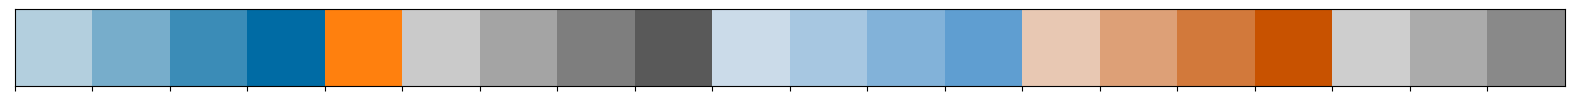

In [106]:
imp_order = eval_df.reset_index().sort_values(['ctrl', 'group', 'imputation'])[['group', 'imputation']].drop_duplicates()
colors = imp_order['group'].unique()
n_colors = [len(imp_order[imp_order['group'] == c]) for c in colors]

def generate_color_palette(color_list):
    # Generate a base color palette
    base_palette = sns.color_palette(
        ['#006BA4', '#FF800E', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF'], 
        n_colors=len(color_list))
    
    # Generate shades for each base color
    color_palette = []
    for i, color in enumerate(base_palette):
        shades = sns.light_palette(color, n_colors=color_list[i] + 1)
        color_palette.extend(shades[1:])
    
    return color_palette


# Generate the color palette
cset = generate_color_palette(n_colors)
sns.palplot(cset)
print(dict(zip(colors, n_colors)))

In [ ]:
# n_col = len(set(df.reset_index()['imputation']))
# cmap=matplotlib.cm.get_cmap('cividis', n_col)
# cset = [cmap(i) for i in range(n_col)]

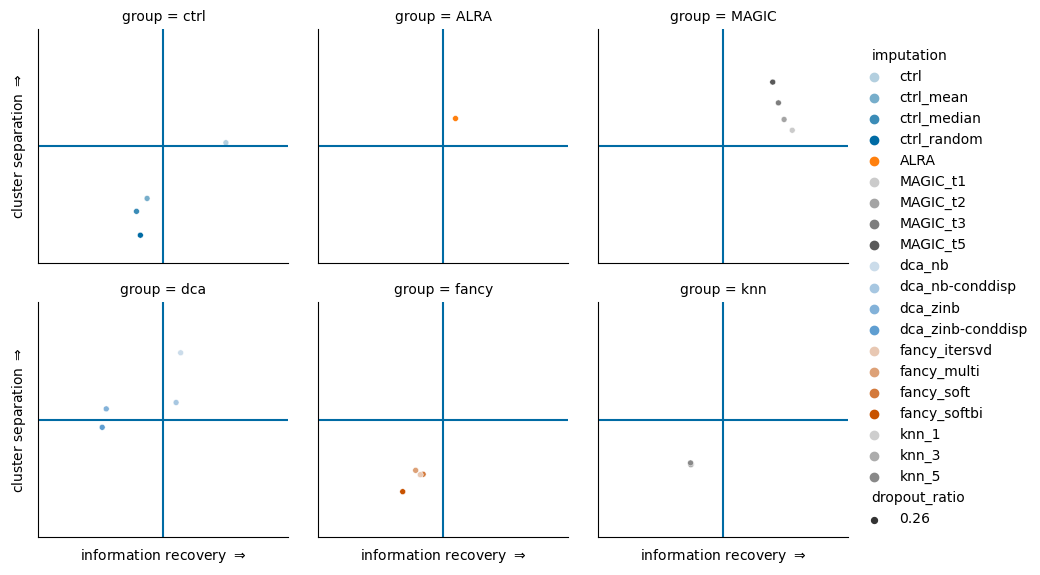

In [107]:
from scipy.interpolate import splprep, splev
eval_plot = sns.relplot(
    data=eval_df.reset_index(), 
    x='information_recovery', 
    y='cluster_separation', 
    size='dropout_ratio',
    col='group', col_wrap=3,
    col_order=colors,
    hue='imputation', 
    hue_order=imp_order['imputation'],
    height=3, aspect=1, palette=cset)

eval_plot.set_xlabels(r'information recovery $\Rightarrow$')
eval_plot.set_ylabels(r'cluster separation $\Rightarrow$')
# max_ext = max(
#     np.max(np.abs(eval_df['information_recovery'])),
#     np.max(np.abs(eval_df['cluster_separation']))
# ) + 0.1
for ax in eval_plot.axes.flat:
    # ax.axhline(0) 
    # ax.axvline(0)
    ax.axhline(0.5) 
    ax.axvline(0.5)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

from adjustText import adjust_text
for (row, col, hue), data_table in list(eval_plot.facet_data()):
    for i, imputation in enumerate(imp_order['imputation']):
        data = data_table[data_table['imputation'] == imputation]
        if len(data) > 1:
            tck, u = splprep([data['information_recovery'], data['cluster_separation']], s=0)
            u_new = np.linspace(u.min(), u.max(), 100)
            x_new, y_new = splev(u_new, tck, der=0)
            data = data.reset_index()
            #eval_plot.axes.flat[col].plot(x_new, y_new, color=cmap(i)[:3], linewidth=1)
            for j in range(len(data['information_recovery']) - 1):
                eval_plot.axes.flat[col].plot([data['information_recovery'][j], data['information_recovery'][j+1]],
                            [data['cluster_separation'][j], data['cluster_separation'][j+1]],
                            color=cset[i],
                            # color=cmap(i)[:3], 
                            linewidth=1)
    
eval_plot.fig.savefig(os.path.join(save_to, 'robustness_area_plot.pdf'))   
#eval_plot.axes.flat[0].set_title(f'Imputation methods on Glioblastoma dataset')

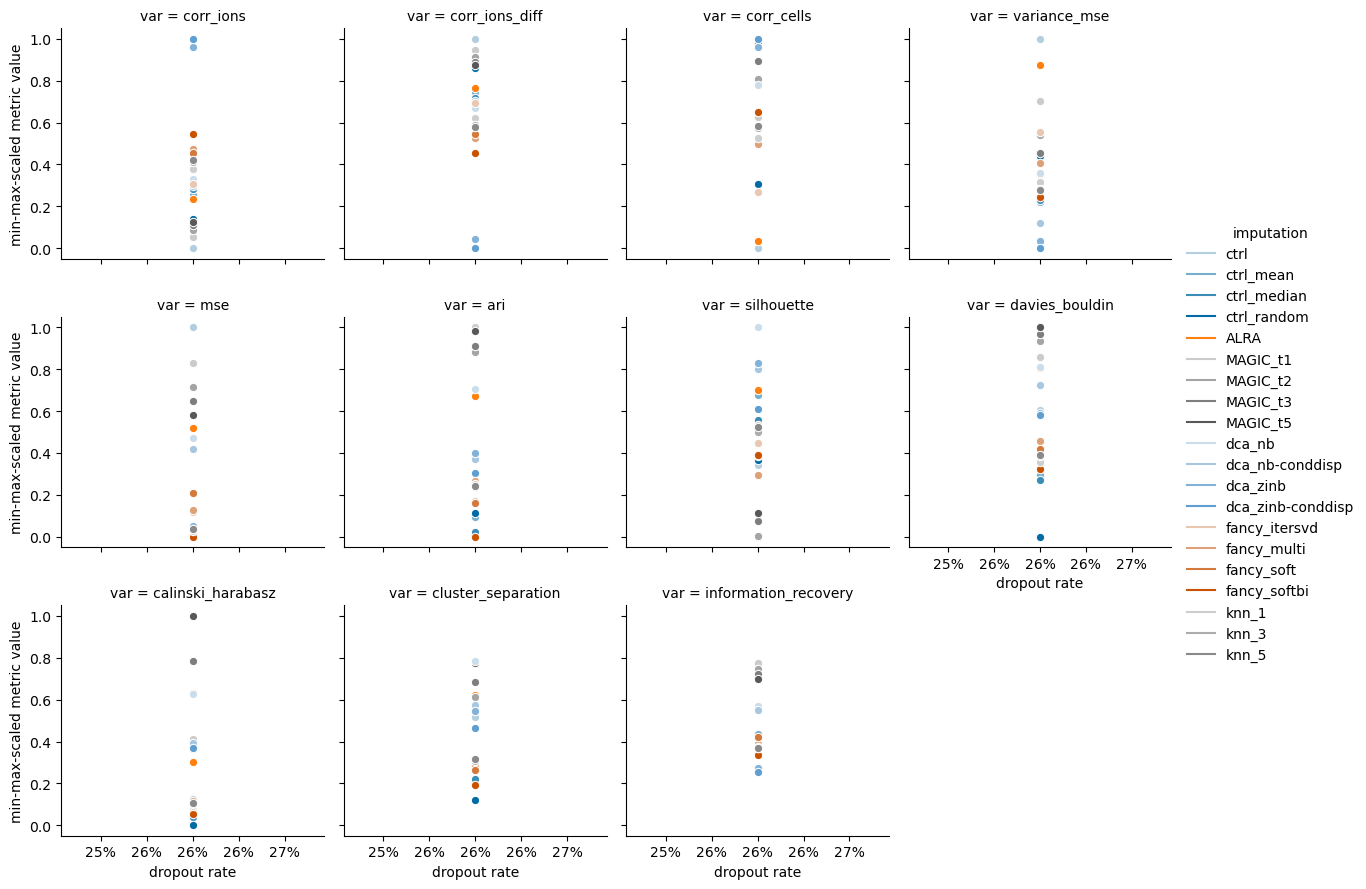

In [108]:
import matplotlib.ticker as mtick

pl = sns.relplot(
    eval_df.reset_index().melt(id_vars=['dr', 'dropout_ratio', 'imputation', 'group', 'simulation', 'ctrl'], var_name='var'), 
    x='dropout_ratio', y='value',
    col='var', col_wrap=4,
    kind='line', marker='o',
    hue='imputation', hue_order = imp_order['imputation'], palette=cset,
    height=3, aspect=1)

# Create a function to format the y-axis ticks as percentages
def percent_formatter(x, pos):
    return '{:.0%}'.format(x)

# Apply the percent formatter to the y-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))
pl.set_xlabels(r'dropout rate')
pl.set_ylabels(r'min-max-scaled metric value')
pl.fig.savefig(os.path.join(save_to, 'performance_details.pdf')) 

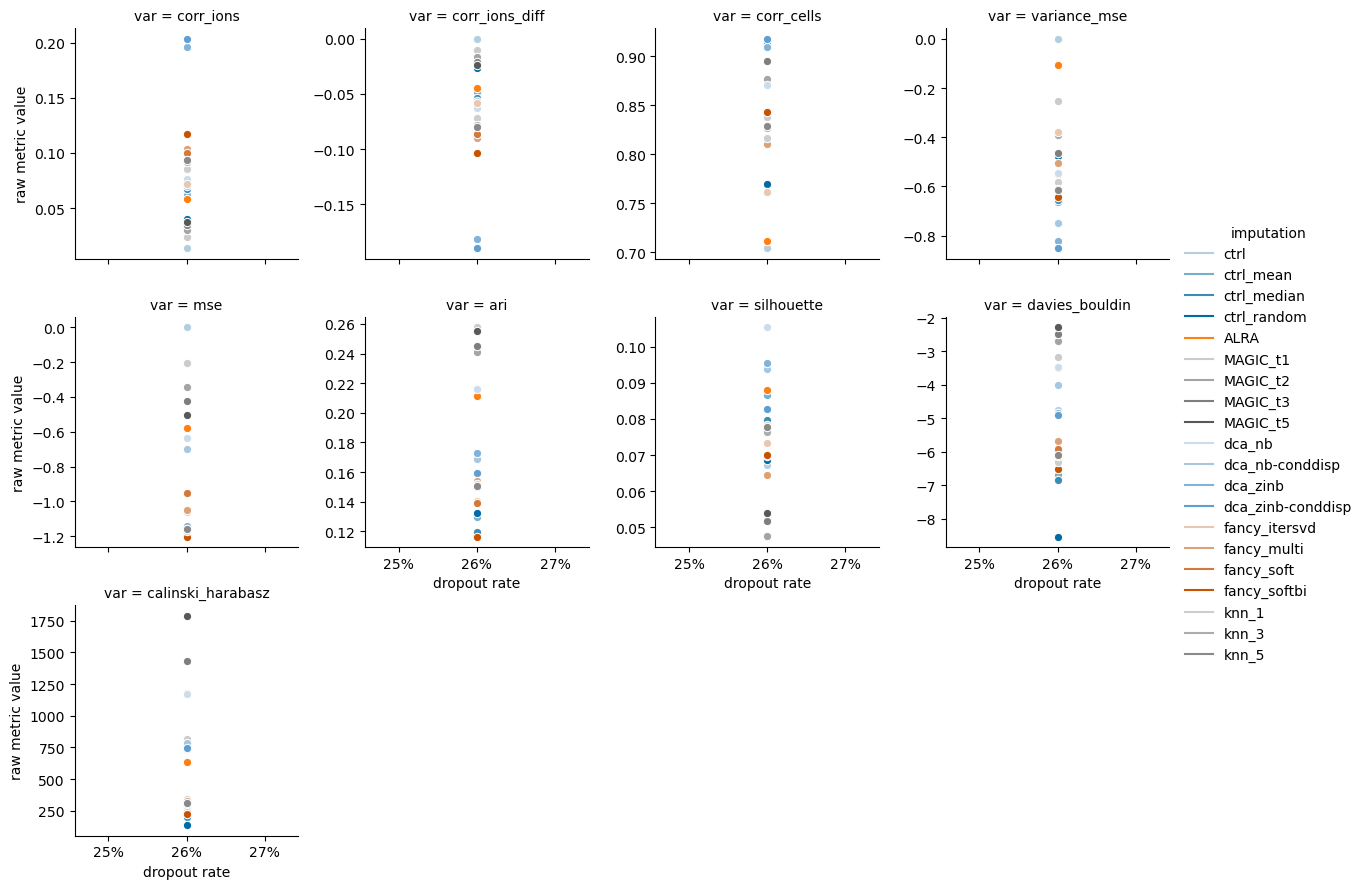

In [109]:
pl = sns.relplot(
    df.reset_index().melt(id_vars=['dr', 'dropout_ratio', 'imputation', 'group', 'simulation'], var_name='var'), 
    x='dropout_ratio', y='value',
    col='var', col_wrap=4,
    kind='line', marker='o',
    height=3, aspect=1, 
    palette=cset, hue='imputation',
    hue_order=imp_order['imputation'],
    facet_kws={'sharey': False}
)

# Apply the percent formatter to the y-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))
pl.set_xlabels(r'dropout rate')
pl.set_ylabels(r'raw metric value')
pl.fig.savefig(os.path.join(save_to, 'performance_details_raw.pdf')) 

KeyboardInterrupt: 

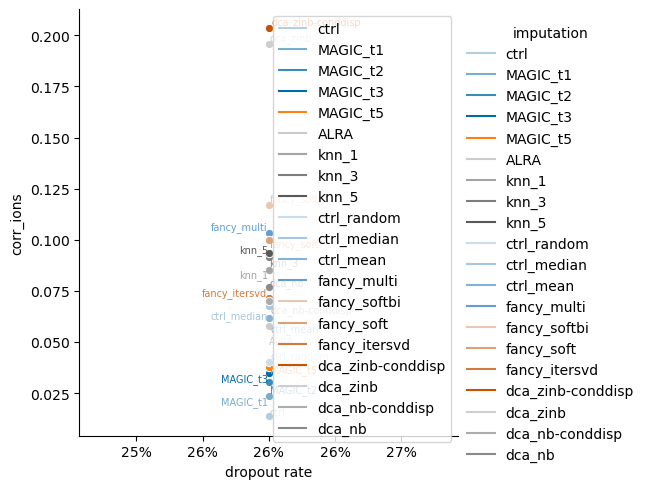

In [110]:
for metric in df.columns:
    ind_plot = sns.relplot(df, x='dropout_ratio', y=metric, hue='imputation', marker="o", kind='line', palette=cset)
    plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))
    ind_plot.set_xlabels(r'dropout rate')
    scid.ev.utils.print_labels_on_line_canvas(ind_plot, offset=0.02)
    ind_plot.fig.savefig(os.path.join(save_to, f'performance_detail_{metric}.pdf')) 

In [ ]:
save_umaps = os.path.join(save_to, 'umaps')
if not os.path.exists(save_umaps):
    os.makedirs(save_umaps)
sc.settings.figdir=save_umaps

for i in range(len(wflow.adata_list)):
    fig = sc.pl.umap(
        wflow.adata_list[i]['adata'], color='condition', 
        title=f"{wflow.adata_list[i]['dropout_ratio']}_{wflow.adata_list[i]['imputation']}",
        save=os.path.join(f"{wflow.adata_list[i]['dropout_ratio']}_{wflow.adata_list[i]['imputation']}.png")
    )

In [20]:
def _evaluate_imputation(params):
    l = params
    adata = l['adata']

    u_df = sc.get.obs_df(
        adata, 
        keys=[const.SAMPLE_COL, const.BATCH_COL, const.CONDITION_COL] + wflow.analysis_ions, 
        obsm_keys=[("X_umap", 0), ("X_umap", 1)]
    )   

    out_df = u_df
    out_df['imputation']=l['imputation']
    out_df['dr']=l['dropout_ratio']

    return out_df

# these calculations are a bit heavier, running >5 in parallel can lead to memory issues
umap_df = wflow.analyse_imputation(function = _evaluate_imputation, n_jobs=1, verbose=50)
umap_df

100%|██████████| 114/114 [00:00<00:00, 157.70it/s]


,sample,batch,condition,C7H10O6+Cl,C4H9O7P-H,C4H7NO4+Cl,C10H13N4O8P-H,C5H4N4O-H,C10H13N4O9P-H,C10H16N2O3S+Cl,C11H23N5O3S+Cl,X_umap-0,X_umap-1,imputation,dr,dropout_ratio
cell_id,,,,,,,,,,,,,,,,
160_B3,B3,none,2DG,3.219958,2.647845,1.668519,0.000000e+00,0.000000,0.000000,0.000000e+00,2.222448,2.084774,-5.303170,ctrl,0.36_baseline,0.36
161_B3,B3,none,2DG,3.636109,3.211338,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,2.244551,1.369684,-5.910446,ctrl,0.36_baseline,0.36
162_B3,B3,none,2DG,3.713668,3.482151,0.000000,0.000000e+00,0.000000,2.003449,0.000000e+00,2.337734,2.649898,-5.827819,ctrl,0.36_baseline,0.36
165_B3,B3,none,2DG,0.000000,0.000000,0.000000,1.987721e+00,0.000000,0.000000,0.000000e+00,2.777914,4.064525,-2.840241,ctrl,0.36_baseline,0.36
166_B3,B3,none,2DG,3.791214,3.045377,0.000000,0.000000e+00,1.402989,0.000000,0.000000e+00,2.402378,0.395342,-4.403181,ctrl,0.36_baseline,0.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10324_E1,E1,none,NStim,2.452209,1.828816,0.149095,1.744397e-03,0.001706,0.000885,1.501315e-04,2.219569,-1.143494,3.306072,dca_nb,0.84,0.84
10329_E1,E1,none,NStim,1.641504,0.612973,0.031578,4.260560e-04,0.023128,0.028868,1.426153e-06,1.180421,7.705026,3.840694,dca_nb,0.84,0.84
10334_E1,E1,none,NStim,0.744611,0.723432,0.126631,1.048172e-01,0.000901,0.001634,1.125219e-04,3.441726,2.698831,8.436209,dca_nb,0.84,0.84


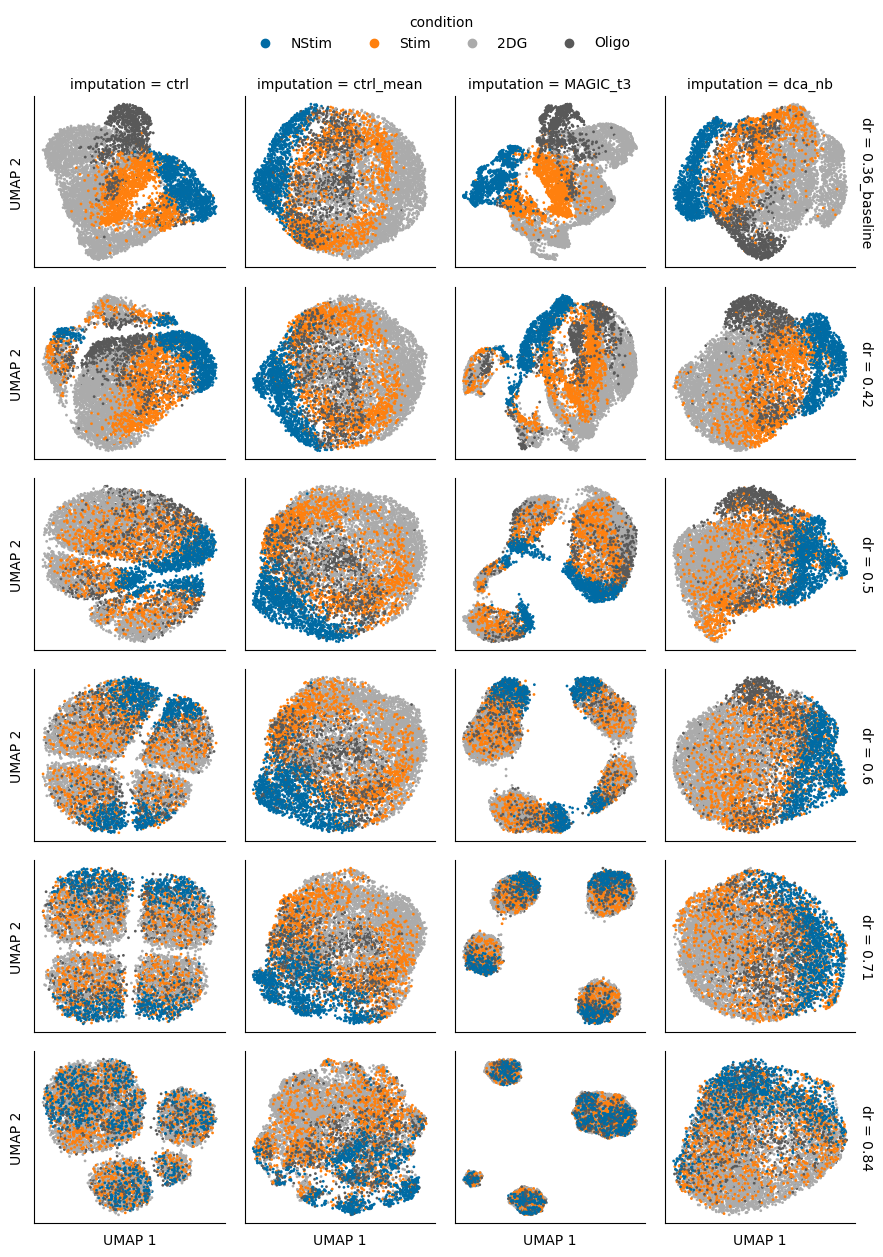

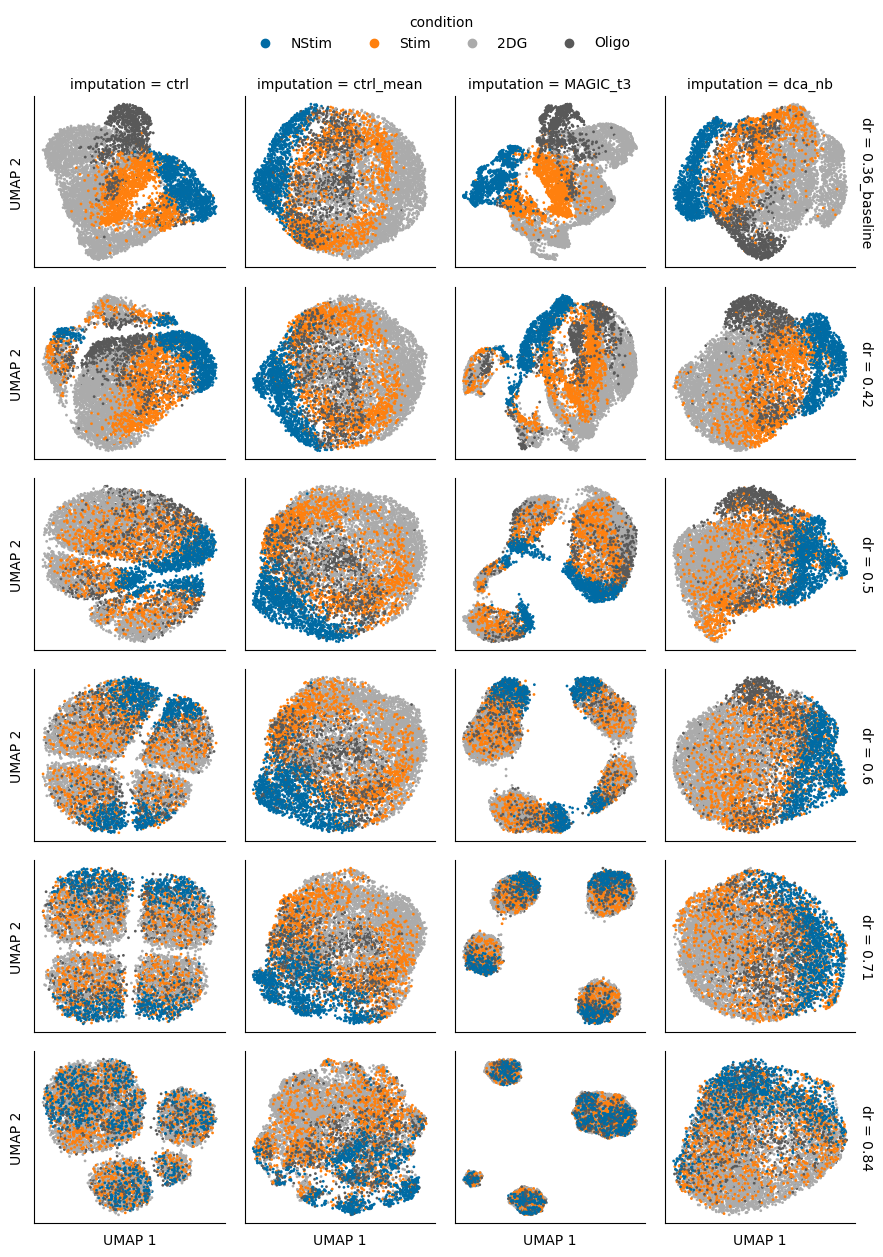

In [23]:
cond=4 
subset = dict(
    all=umap_df.imputation.unique(),
    main=['ctrl', 'ctrl_mean', 'MAGIC_t3', 'dca_nb'],
)
for subset, conditions in subset.items():
    plot = sns.relplot(
        data=umap_df, 
        x='X_umap-0', y='X_umap-1', s=4, linewidth=0,
        row='dr', col='imputation', col_order=['ctrl', 'ctrl_mean', 'MAGIC_t3', 'dca_nb'],
        hue='condition', hue_order=['NStim', 'Stim', '2DG', 'Oligo'],
        facet_kws=dict(margin_titles=True, sharex=False, sharey=False), 
        height=2)

    plot.set_xlabels('UMAP 1')
    plot.set_ylabels('UMAP 2')
    for ax in plot.axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    plot.fig.tight_layout()
    sns.move_legend(plot, "lower center", bbox_to_anchor=(0.5, 1), ncol=cond)
    plot.fig.savefig(os.path.join(save_to, f'umap_{subset}.pdf'))
    plot.fig.savefig(os.path.join(save_to, f'umap_{subset}.png'))